# Age detection in cathegories from images

# Importing Libraries

In [77]:

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries.

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, SGD, RMSprop, Nadam


In [ ]:
# pip install seaborn

In [ ]:
# pip install tensorflow

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# print(device_lib.list_local_devices())

# Displaying Images

In [2]:
picture_size = 48
folder_path = "./images/face_age/"

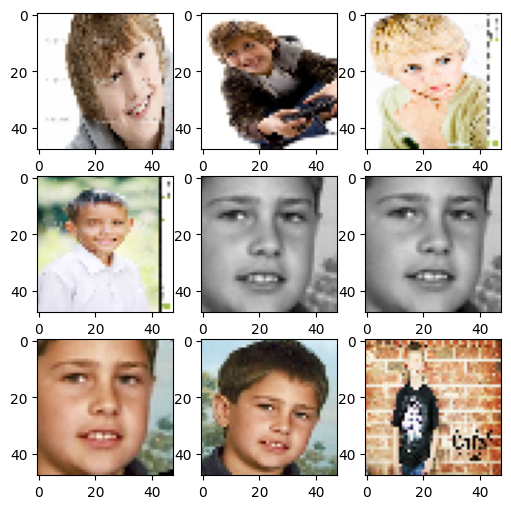

In [3]:

age_folder_1 = "000"

plt.figure(figsize= (6, 6))

for i in range(1, 10, 1):
    
    plt.subplot(3,3,i)
    img = load_img(folder_path + "train/" + age_folder_1 + "/" +
                  os.listdir(folder_path + "train/" + age_folder_1)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
    
plt.show()


# Making Training and Validation Data (with generator)

In [5]:

batch_size  = 128

# ImageDataGenerator with rescaling
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)


test_set = datagen_val.flow_from_directory(folder_path+"validate",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)


Found 28983 images belonging to 5 classes.
Found 7225 images belonging to 5 classes.


# Making Training and Validation Data (without generator, old fashioned way)

In [6]:

# Converts the age label to an integer.
def convert_age_label_to_int(age_label):
    
   # Convert the extracted part to an integer.
   age_number = int(age_label)

   return age_number
    
# Converts an integer to an age label.
def convert_int_to_age_label(age_number):
    
   # Convert integer i to label "00i".
   age_label = f"{age_number:03}"

   return age_label

# Calculates and fills the vector age_size with the number of files in each "age" folder.
# Choose train_or_validate to "train" or "validate". 
def get_nr_of_files_in_folders(age_folders, folder_path, train_or_validate, age_size):

    for j in range(len(age_folders)):
        
       folder = folder_path + f"{train_or_validate}/" + age_folders[j]

       # Using os.scandir() to get only files in a folder
       with os.scandir(folder) as entries:
            num_files = len([entry.name for entry in entries if entry.is_file()])

       age_size.append(num_files)

# Check time to run program (loads x (images) and creates y ('age labels') for train and validation data).
# Start time counter.
start_time_program = time.perf_counter()

images_data_train = []
images_labels_train = []

images_data_val = []
images_labels_val = []

age_labels = [convert_int_to_age_label(age_val) for age_val in range(0, 100, 20)]
age_folders = age_labels.copy()

age_size_train = []
age_size_val = []

get_nr_of_files_in_folders(age_folders, folder_path, "train", age_size_train)

get_nr_of_files_in_folders(age_folders, folder_path, "validate", age_size_val)

# Function that creates the training data with the labels.

def createDataFromImagesTrainSet(age_labels, age_folders, age_size_train):

   index = 0

   for j in range (len(age_folders)):
    
      for i in range(age_size_train[j]):

          img = load_img(folder_path + "train/" + age_folders[j] + "/" +
                     os.listdir(folder_path + "train/" + age_folders[j])[i], target_size=(picture_size, picture_size), color_mode = 'rgb')

          image_data_raw = img_to_array(img)
          image_data_raw = image_data_raw / 255.0
          images_labels_train.append(age_labels[j])
          images_data_train.append(image_data_raw)
     
          index += 1

# Function that creates the testing data with the labels.

def createDataFromImagesValSet(age_labels, age_folders, age_size_val):

   index = 0

   for j in range (len(age_folders)):
    
      for i in range(age_size_val[j]):

          img = load_img(folder_path + "validate/" + age_folders[j] + "/" +
                     os.listdir(folder_path + "validate/" + age_folders[j])[i], target_size = (picture_size, picture_size), color_mode = 'rgb')

          image_data_raw = img_to_array(img)
          image_data_raw = image_data_raw / 255.0
          images_labels_val.append(age_labels[j])
          images_data_val.append(image_data_raw)
     
          index += 1


# Creates the training data with the labels.
createDataFromImagesTrainSet(age_labels, age_folders, age_size_train)

# Creates the testing data with the labels.
createDataFromImagesValSet(age_labels, age_folders, age_size_val)


# Convert to an np array.
    
images_labels_train = np.array(images_labels_train)
images_data_train = np.array(images_data_train)

images_labels_val = np.array(images_labels_val)
images_data_val = np.array(images_data_val)

# Stop time counter and write result.
end_time_program = time.perf_counter()
str_info = f"The time to run the program, where it (loads 'x' ('images') and creates 'y' ('age labels') for train and validation data)"
diff_time = end_time_program - start_time_program
print(f"\n" + f"{str_info}. It takes {diff_time:.0f} s ({diff_time // 60:.0f} min {diff_time % 60:.0f} sek).\n")



The time to run the program, where it (loads 'x' ('images') and creates 'y' ('age labels') for train and validation data). It takes 455 s (7 min 35 sek).



In [7]:

print(len(images_labels_train))
print(len(images_data_val))
print("")
print(len(age_labels))
print(age_labels)
# print(age_folders)
# print(age_labels.index('000'))
print(len(age_size_train))
print(len(age_size_val))

print(age_size_train)
print(age_size_val)

age_size_quota = []
age_size_sum = []
for i in range(len(age_size_train)):
   age_size_quota.append(round(age_size_train[i] / age_size_val[i]))
   age_size_sum.append((age_size_train[i] + age_size_val[i]))
    
print(age_size_quota)
print(age_size_sum)

print((sum(age_size_val) / (sum(age_size_val) + sum(age_size_train))))


28983
7225

5
['000', '020', '040', '060', '080']
5
5
[8153, 12112, 5294, 2499, 925]
[2155, 3022, 1265, 584, 199]
[4, 4, 4, 4, 5]
[10308, 15134, 6559, 3083, 1124]
0.1995415377817057


# Manipulating the input and output data.

In [9]:
        
# Generate a permutation of indices for train data.

permutation_train = np.random.permutation(len(images_data_train))

# Shuffle twice the train data and labels using the permutation.

images_data_train = images_data_train[permutation_train]
images_labels_train = images_labels_train[permutation_train]

permutation_train2 = np.random.permutation(len(images_data_train))

images_data_train = images_data_train[permutation_train2]
images_labels_train = images_labels_train[permutation_train2]

# Generate a permutation of indices for validation data.

permutation_val = np.random.permutation(len(images_data_val))

# Shuffle twice the validation data and labels using the permutation.

images_data_val = images_data_val[permutation_val]
images_labels_val = images_labels_val[permutation_val]

permutation_val2 = np.random.permutation(len(images_data_val))

images_data_val = images_data_val[permutation_val2]
images_labels_val = images_labels_val[permutation_val2]

# Make the age cathegories to integer values and one-hot encoding.

label_encoder = LabelEncoder()
integer_labels_train = label_encoder.fit_transform(images_labels_train)
integer_labels_val = label_encoder.transform(images_labels_val) 

images_labels_train_cat = to_categorical(integer_labels_train, num_classes = len(age_labels))
images_labels_val_cat = to_categorical(integer_labels_val, num_classes = len(age_labels))


In [10]:

# print(images_labels_train_cat[:20], images_labels_train[:20])
# print(images_labels_val_cat[:20], images_labels_val[:20])

print(len(integer_labels_train))
print(len(integer_labels_val))

# print(max(integer_labels_train))
# print(max(integer_labels_val))

# Check unique classes
unique_classes_train = np.unique(integer_labels_train)
print(f"Unique classes (train): {len(unique_classes_train)}")

unique_classes_val = np.unique(integer_labels_val)
print(f"Unique classes (val): {len(unique_classes_val)}")

unique_classes_age = np.unique(age_labels)
print(f"Unique classes (age_labels): {len(unique_classes_age)}")

print(len(age_labels))
# print(age_labels)


28983
7225
Unique classes (train): 5
Unique classes (val): 5
Unique classes (age_labels): 5
5


# Model Building

In [191]:

# The neural network model with convutional and dense layers.

# The number of classes: 'no_of_classes' = 5 age cathegories.
no_of_classes = len(age_labels)

# The l2 regulariztion parameter (l2_score).
l2_score = 0.01

model = Sequential()

# Define input shape here.
model.add(Input(shape=(48, 48, 3)))  

#1st CNN layer
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(l2_score)))
# model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128, (5,5), padding = 'same', kernel_regularizer=l2(l2_score)))
# model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3), padding = 'same', kernel_regularizer=l2(l2_score)))
# model.add(Conv2D(512,(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=l2(l2_score)))
# model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(1024, kernel_regularizer=l2(l2_score)))
# model.add(Dense(1024), kernel_regularizer=l2(l2_score)))
# model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected 2nd layer
model.add(Dense(2024, kernel_regularizer=l2(l2_score)))
# model.add(Dense(1024), kernel_regularizer=l2(l2_score)))
# model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 3d layer
# model.add(Dense(2024, kernel_regularizer=l2(l2_score)))
## model.add(Dense(1024, kernel_regularizer=l2(l2_score)))
## model.add(Dense(512))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# Output layer (no_of_classes = 5 age cathegories).
model.add(Dense(no_of_classes, activation='softmax'))

my_learning_rate = 0.0005

# Optimizer Adam (there are also SGD, RMSprop and Nadam).
opt = Adam(learning_rate = my_learning_rate)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_80 (Conv2D)              │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_135         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_135 (Activation)     │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_136 (Activation)     │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_137 (Activation)     │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_138         │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_138 (Activation)     │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_139         │ (None, 1024)           │         4,09

 Total params: 9,978,261 (38.06 MB)

 Trainable params: 9,969,733 (38.03 MB)

 Non-trainable params: 8,528 (33.31 KB)

In [ ]:
# print(no_of_classes)

# Fitting the Model with Training and Validation Data 

In [192]:

# Fitting the Model with Training and Validation Data. 
# Using callbacks as ModelCheckpoint, EarlyStopping and ReduceLROnPlateau.

checkpoint = ModelCheckpoint("./modelcheck_age.keras", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 60

# Optimizer Adam (there are also SGD, RMSprop and Nadam).
opt = Adam(learning_rate = my_learning_rate)
model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])


# Training models.

In [ ]:

# Fit the model with the generator model.

# history = model.fit(train_set,
#                    steps_per_epoch = train_set.n // train_set.batch_size,
#                    epochs = epochs,
#                    validation_data = test_set,
#                    validation_steps = test_set.n // test_set.batch_size,
#                    callbacks = callbacks_list
#                    )


In [ ]:

# Fit the model with the generator model.

history = model.fit(train_set,
                    steps_per_epoch = train_set.n // train_set.batch_size,
                    epochs = epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n // test_set.batch_size,
                    callbacks = callbacks_list
                    )


In [193]:

# Fit the model where x (images) and y ('age categories') has been "loaded" from file.

# Check time to run the program (train the neural network model).
# Start time counter.
start_time_program = time.perf_counter()

batch_size_img = 128

history = model.fit(x = images_data_train, y = images_labels_train_cat,
                    steps_per_epoch = max(len(images_data_train) // batch_size_img - 5 , 1),
                    epochs = epochs,
                    batch_size = batch_size_img,
                    validation_data = (images_data_val, images_labels_val_cat),
                    validation_steps = max(len(images_data_val) // batch_size_img - 5, 1),
                    callbacks = callbacks_list
                    )

# Stop time counter and write result.
end_time_program = time.perf_counter()
str_info = f"The time to run the program, where it trains the neural network"
diff_time = end_time_program - start_time_program
print(f"\n" + f"{str_info}, is given by {diff_time:.0f} s ({diff_time // 60:.0f} min {diff_time % 60:.0f} sek).\n")


Epoch 1/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.4386 - loss: 28.5228
Epoch 1: val_accuracy improved from -inf to 0.18689, saving model to ./modelcheck_age.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 151s 671ms/step - accuracy: 0.4388 - loss: 28.4813 - val_accuracy: 0.1869 - val_loss: 6.5766 - learning_rate: 5.0000e-04
Epoch 2/60
  6/221 ━━━━━━━━━━━━━━━━━━━━ 1:52 525ms/step - accuracy: 0.4763 - loss: 6.3766

D:\Program\Programming\Anaconda3\envs\Lia_AI1\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.18689
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4889 - loss: 6.2608 - val_accuracy: 0.0703 - val_loss: 6.6084 - learning_rate: 5.0000e-04
Epoch 3/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.5285 - loss: 4.2982
Epoch 3: val_accuracy improved from 0.18689 to 0.48713, saving model to ./modelcheck_age.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 143s 646ms/step - accuracy: 0.5285 - loss: 4.2935 - val_accuracy: 0.4871 - val_loss: 2.1125 - learning_rate: 5.0000e-04
Epoch 4/60
  6/221 ━━━━━━━━━━━━━━━━━━━━ 1:55 538ms/step - accuracy: 0.5775 - loss: 2.0027
Epoch 4: val_accuracy did not improve from 0.48713
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5784 - loss: 2.0071 - val_accuracy: 0.3888 - val_loss: 2.3374 - learning_rate: 5.0000e-04
Epoch 5/60
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.5557 - loss: 1.8316
Epoch 5: val_accuracy did not improve from 0.48713
221/221 ━━━━━━━━━━━━━━━━━━━━ 141s 637ms/step

# Saving the models (and loading checkpoint model with best accuracy).

In [197]:

model.save(filepath = "model_age.keras", include_optimizer = False)

model.save(filepath = "model_all_age.keras")

model2 = load_model("modelcheck_age.keras")


In [199]:

# Load the models from disk for prediction, accuracy and confusion matrix.

model2 = load_model("modelcheck_age.keras")
model = load_model("model_all_age.keras")


# Calculate the accuracy from the validation data.

In [200]:

# Create predictions from the validation data (from last trained model (model) and best accuracy checkpoint model (model2)).

pred_val = model.predict(images_data_val)
pred_val2 = model2.predict(images_data_val)


226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step


In [201]:

# Make predictions and evaluate the model.

# Accuracy from last trained model (model).

pred_labels_val = np.argmax(pred_val, axis=1)
true_labels_val = np.argmax(images_labels_val_cat, axis=1)
accuracy = np.mean(pred_labels_val == true_labels_val)
print(f"Accuracy: {accuracy}")

# Accuracy from best accuracy checkpoint model (model2).

pred_labels_val2 = np.argmax(pred_val2, axis=1)
accuracy_best = np.mean(pred_labels_val2 == true_labels_val)
print(f"Accuracy (last best prediction): {accuracy_best}")


Accuracy: 0.7223529411764706
Accuracy (last best prediction): 0.7262283737024221


# Plotting Accuracy & Loss

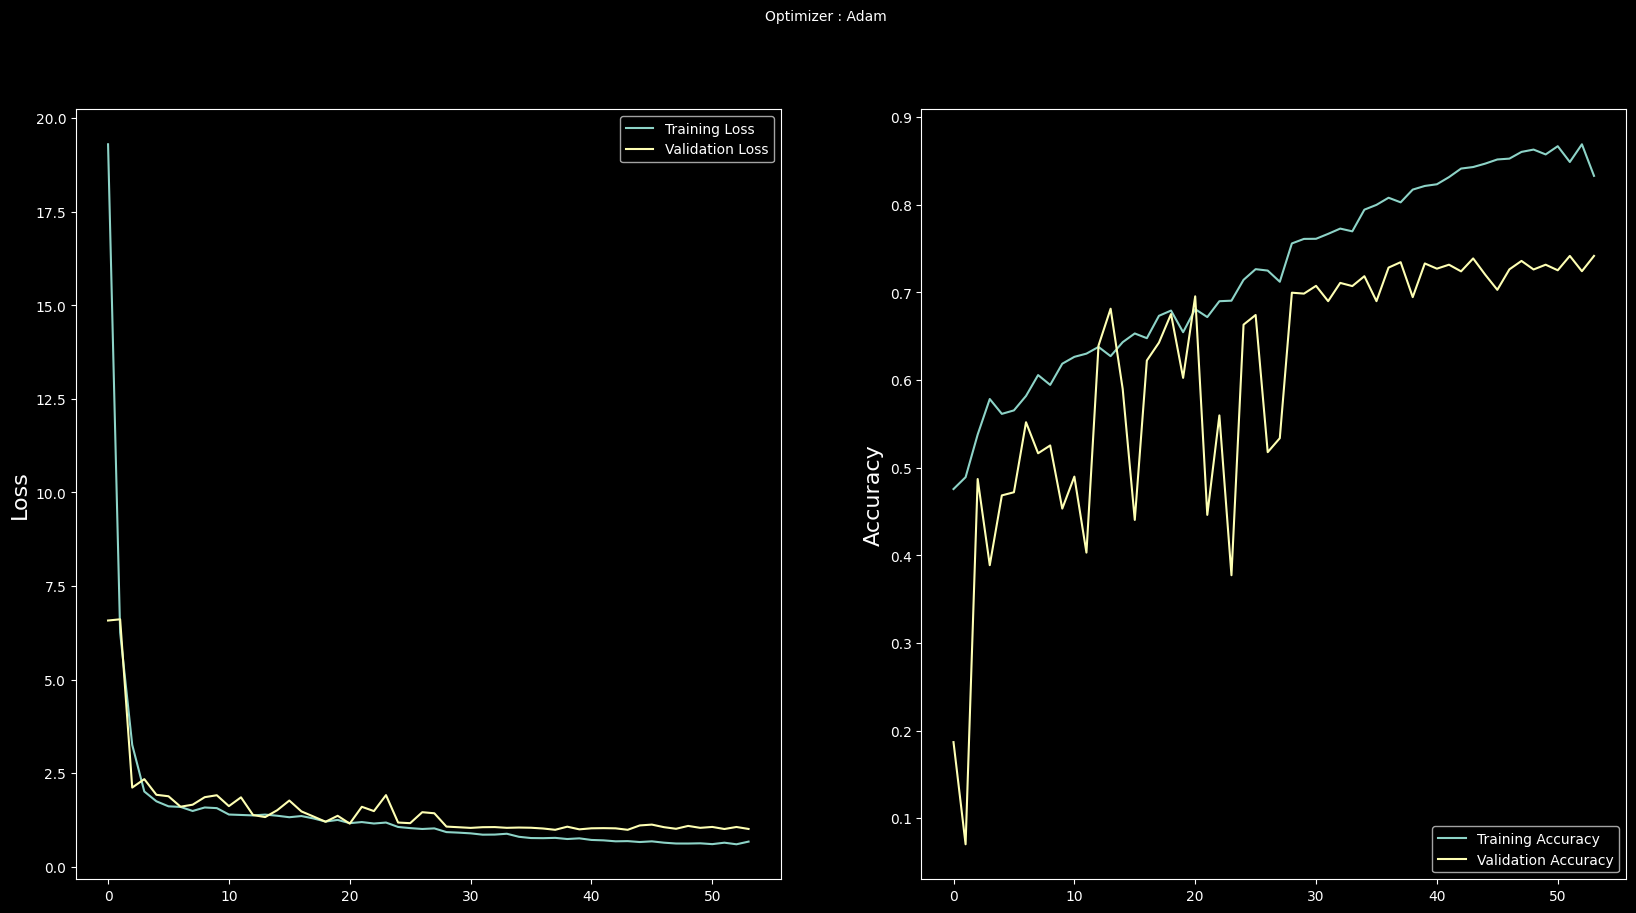

In [202]:

plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


# Confusion matrix

Unique classes 2: 5
Unique classes 1: 5
Unique classes true: 5


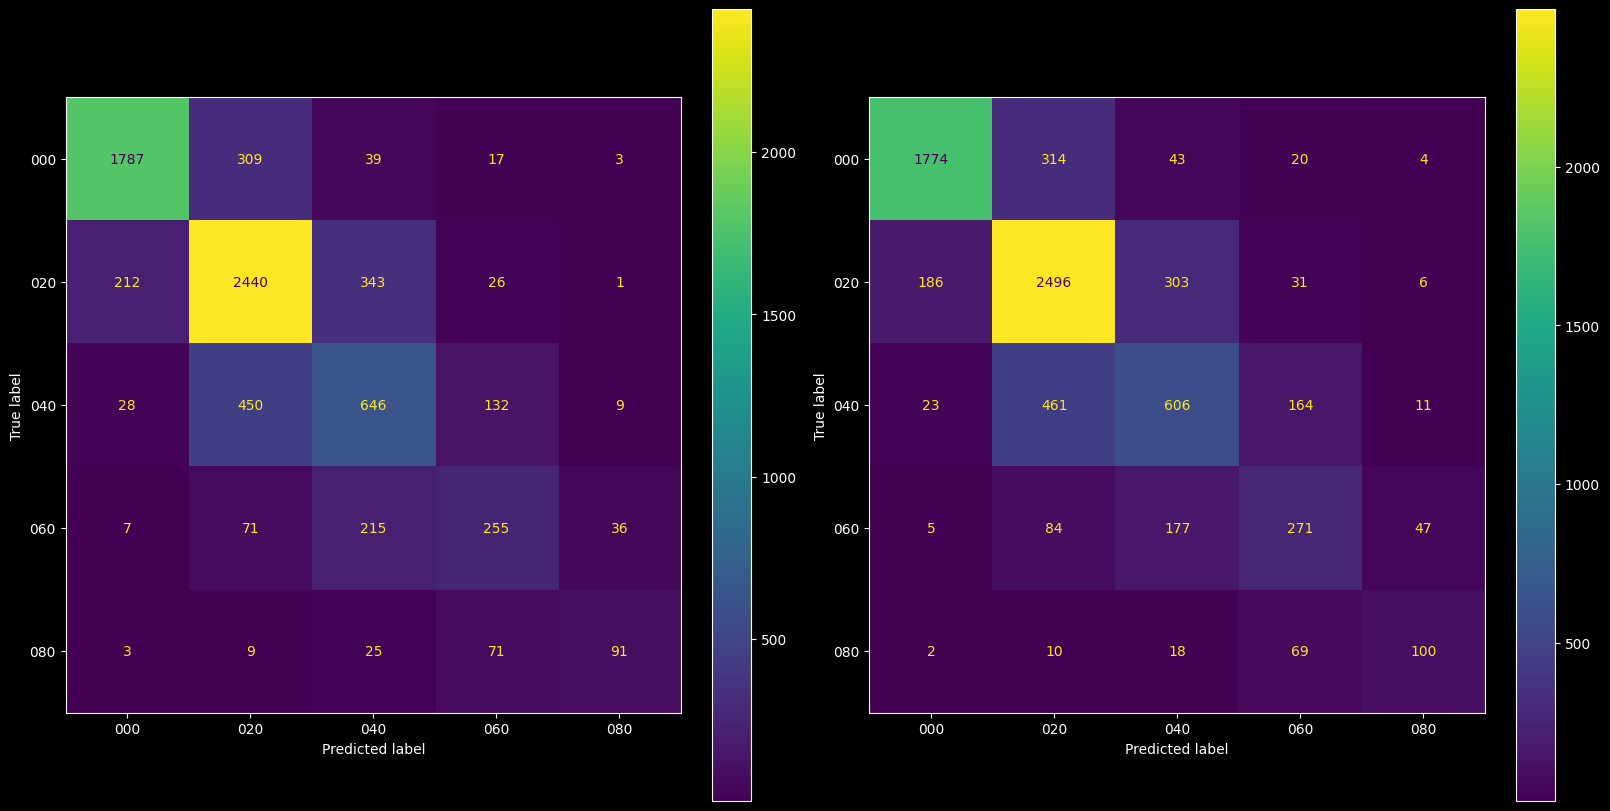

In [203]:

# Calculate the confusion matrix from the predicted and true values (from model (last saved configuration) and 
# model 2 (the best configuration)).

cm1 = confusion_matrix(true_labels_val, pred_labels_val)
cm2 = confusion_matrix(true_labels_val, pred_labels_val2)

# Check unique classes                                          
unique_classes = np.unique(pred_labels_val2)
print(f"Unique classes 2: {len(unique_classes)}")

unique_classes1 = np.unique(pred_labels_val)
print(f"Unique classes 1: {len(unique_classes1)}")

unique_classes_true = np.unique(true_labels_val)
print(f"Unique classes true: {len(unique_classes_true)}")

fig, axs = plt.subplots(1, 2, figsize = (16, 8), layout='constrained')
ConfusionMatrixDisplay(cm1, display_labels = age_labels).plot(ax=axs[0])
ConfusionMatrixDisplay(cm2, display_labels = age_labels).plot(ax=axs[1])
